In [1]:
##imports
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from pathlib import Path
import shutil
import pandas as pd  
import richdem as rd
import albumentations as albu
import torch
import numpy as np
import segmentation_models_pytorch as smp
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from torch import FloatTensor
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [2]:
train_dirs_path = 'data_cache/MarsData/DataFrames/three_channel_train.csv'
### Uncomment to exclude GAN images for training

#train_dirs_path = 'data_cache/MarsData/DataFrames/three_channel_train(NO GAN).csv'
validate_dirs_path = 'data_cache/MarsData/DataFrames/three_channel_valid.csv'
test_dirs_path = 'data_cache/MarsData/DataFrames/three_channel_test.csv'

In [3]:
### create scaler instance
scaler = MinMaxScaler()

In [4]:
class Dataset(BaseDataset):    
    CLASSES = ['non-mound', 'mound']
    
    def __init__(
          self, 
          dirs,
          classes=None,
          augmentation=None):
        self.df = pd.read_csv(dirs)
        self.ids = self.df.index.to_list()

        ### convert str names to class values on masks
        self.class_values = CLASSES = [0, 1]
        self.augmentation = augmentation
    
    def __getitem__(self, i):
        ### read data
        if self.df.at[i, 'origin'][-3:] == 'tif':
            ### load DEM
            with rasterio.open(self.df.at[i, 'origin'].replace('/content/drive/My Drive/Image Segmentation/Resized Sets','data_cache/MarsData/')) as dem:
                dem_array = dem.read(1)
            ### load hillshade
            with rasterio.open(self.df.at[i, 'hillshade'].replace('/content/drive/My Drive/Image Segmentation/Resized Sets','data_cache/MarsData/')) as hillshade:
                hillshade_array = hillshade.read(1)
            ### load slope
            with rasterio.open(self.df.at[i, 'slope'].replace('/content/drive/My Drive/Image Segmentation/Resized Sets','data_cache/MarsData/')) as slope:
                slope_array = slope.read(1)
            ### load mask label
            with rasterio.open(self.df.at[i, 'mask'].replace('/content/drive/My Drive/Image Segmentation/Resized Sets','data_cache/MarsData/')) as mask:
                mask_array = mask.read(1)
            mask_array = np.where(mask_array == 0.5, 0, mask_array)
            # apply augmentations
            if self.augmentation:
                ### only reshaping, so applying each function separately is ok.
                sample1 = self.augmentation(image=dem_array)
                dem_array= sample1['image']

                sample2 = self.augmentation(image=slope_array)
                slope_array = sample2['image']           

                sample3 = self.augmentation(image=hillshade_array)
                hillshade_array = sample3['image']

            input_array = [dem_array, slope_array, hillshade_array]
            input_array = np.stack(input_array, axis=0).astype('float')
            input_array = FloatTensor(input_array)
            mask_array = FloatTensor(np.expand_dims(mask_array,axis=(0)))
        
        elif self.df.at[i, 'origin'][-3:] == 'jpg':
            ###load the image and corresponding mask label
            image = Image.open(self.df.at[i, 'origin'].replace('/content/drive/My Drive/Image Segmentation/Resized Sets','data_cache/MarsData/'))
            mask = Image.open(self.df.at[i, 'mask'].replace('/content/drive/My Drive/Image Segmentation/Resized Sets','data_cache/MarsData/')).convert('L')
            
            ###convert image to numpy array
            input_array = np.asarray(image)
            input_array.transpose(2, 0, 1).astype('float32')
            mask_array = np.asarray(mask)
            mask_array = scaler.fit_transform(mask_array)
            mask_array = mask_array[ : ,0]            
            input_array = np.resize(input_array, (3, 224, 192))
            mask_array = np.resize(input_array, (224, 192))
            mask_array [mask_array >= 0.5] = 1 
            mask_array [mask_array < 0.5] = 0
            mask_array = FloatTensor(np.expand_dims(mask_array,axis=(0)))    
            input_array = FloatTensor(input_array)

        return input_array, mask_array
      
    def __len__(self):
        return len(self.ids)

In [5]:
dataset = Dataset(train_dirs_path, classes=['mound'])
print(len(dataset))

FileNotFoundError: [Errno 2] No such file or directory: 'data_cache/MarsData/DataFrames/three_channel_train.csv'

In [ ]:
dataset[1]

In [ ]:
### Sample reshaping (X,Y) --> (224,192)
def get_training_augmentation():
    train_transform = [albu.PadIfNeeded(min_height=224, min_width=192, always_apply=True, border_mode=0)]

    return albu.Compose(train_transform)

def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(224, 192)
    ]
    return albu.Compose(test_transform)

In [ ]:
ENCODER = 'se_resnext50_32x4d'
# ENCODER = 'resnet18'
### use imagenet weights
ENCODER_WEIGHTS = 'imagenet' 
# ENCODER_WEIGHTS = 'ssl'
### Sigmoid activation to obtain logits in final layer
ACTIVATION = 'sigmoid' 
CLASSES = [1, 0]
### altenative UNET instead of FPN
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=None, #ENCODER_WEIGHTS, 
    classes=1, 
    in_channels=3,
    activation=ACTIVATION)

In [ ]:
train_dataset = Dataset(train_dirs_path,
                        augmentation=get_training_augmentation(),                         
                        classes=CLASSES)


valid_dataset = Dataset(validate_dirs_path,
                        augmentation=get_validation_augmentation(),                         
                        classes=CLASSES)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers = 0)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True, num_workers = 0)

In [ ]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.Fscore(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=1e-3),
])

optimizer.param_groups[0]['lr']

In [ ]:
device  = torch.device("cuda:3")

In [ ]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model.to(device), 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model.to(device), 
    loss=loss, 
    metrics=metrics, 
    verbose=True,
)

In [ ]:
# train model for 40 epochs
train_loss=[]
valid_loss=[]
train_fscore=[]
valid_fscore=[]
min_loss = float("inf")
max_score = 0
state_not_changed = 0
scheduler1 = ExponentialLR(optimizer, gamma=0.9)
#scheduler2 = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1,)
for i in range(0, 100):
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    train_loss.append(train_logs['dice_loss'])
    valid_loss.append(valid_logs['dice_loss'])
    train_fscore.append(train_logs['fscore'])
    valid_fscore.append(valid_logs['fscore'])
    state_not_changed+=1
    scheduler1.step()
#     scheduler2.step()
    # do something (save model, change lr, etc.)
    if min_loss > valid_logs['dice_loss']:
        min_loss = valid_logs['dice_loss']
        torch.save(model, './best_loss_model.pth')
        print('best_loss_model saved!')
        state_not_changed = 0
        
    if max_score < valid_logs['fscore']:
        max_score = valid_logs['fscore']
        torch.save(model, './best_score_model.pth')
        print('best_score_model saved!')
        state_not_changed = 0
    
    
    if i % 10 == 0 and i != 0:
        print('Current learning rate = '+str(optimizer.param_groups[0]['lr'])+'!')
#         optimizer.param_groups[0]['lr'] /= 10
#         print('Decrease decoder learning rate to '+str(optimizer.param_groups[0]['lr'])+'!')
#         state_not_changed = 0
        
    if state_not_changed == 15:
        print('The model did not improve during the last 15 epochs')
        break

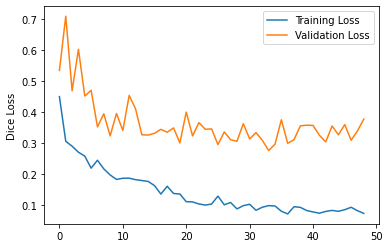

In [21]:
plt.plot(train_loss, label='Training Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.ylabel("Dice Loss")
plt.legend()

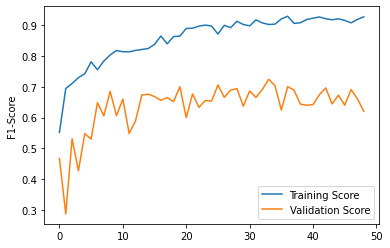

In [22]:
plt.plot(train_fscore, label='Training Score')
plt.plot(valid_fscore, label='Validation Score')
plt.ylabel("F1-Score")
plt.legend()

In [25]:
# create test dataset
test_dataset = Dataset(test_dirs_path,
                       augmentation=get_validation_augmentation())

test_dataloader = DataLoader(test_dataset)

In [26]:
# load best saved checkpoint
# best_model = torch.load('./FPN_3c_Without.pth')
# best_model = torch.load('./FPN_3c_With_Gan.pth')
# best_model = torch.load('./Unet_3c_With_GAN.pth')
# best_model = torch.load('./Unet_3c_Without_GAN.pth')
best_model = torch.load('saved_weights/FPN_3c_Without.pth')

In [27]:
# evaluate model on test set
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.Precision(threshold=0.4),
    smp.utils.metrics.Recall(threshold=0.4),
    smp.utils.metrics.Fscore(threshold=0.4)
]
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics)

logs = test_epoch.run(valid_loader)

valid: 100%|█| 18/18 [05:05<00:00, 16.98s/it, dice_loss - 0.2805, precision - 0.


In [28]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(10, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [29]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(test_dirs_path, 
                           classes=CLASSES)

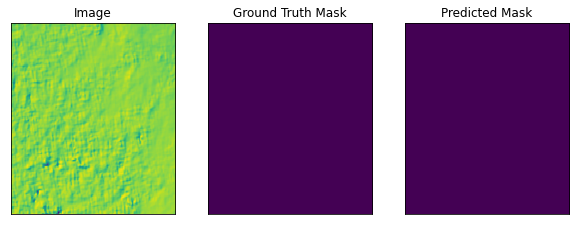

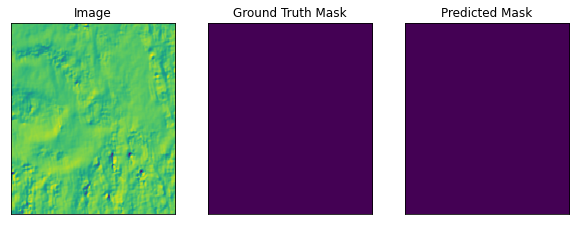

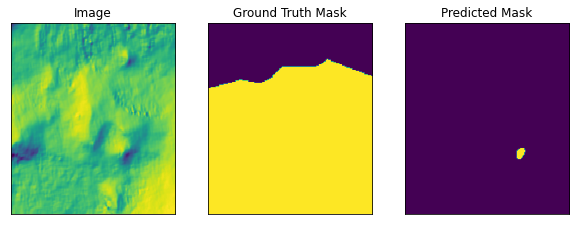

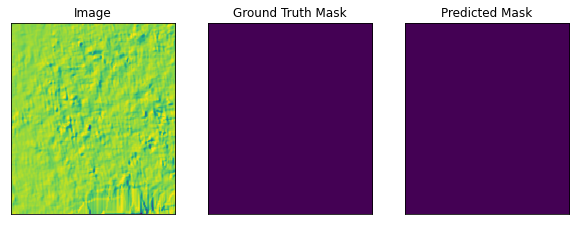

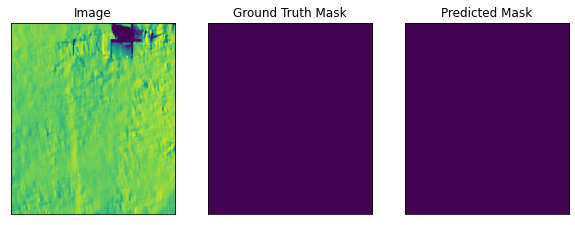

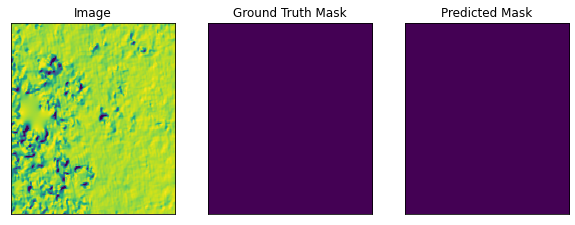

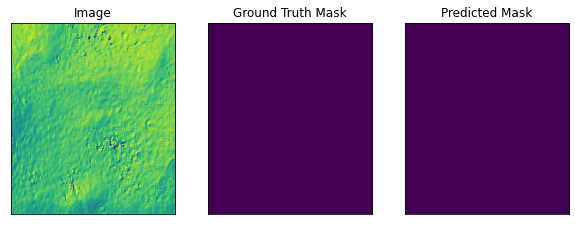

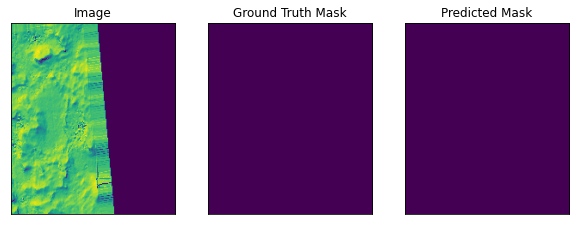

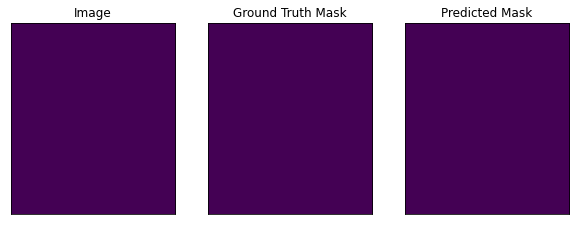

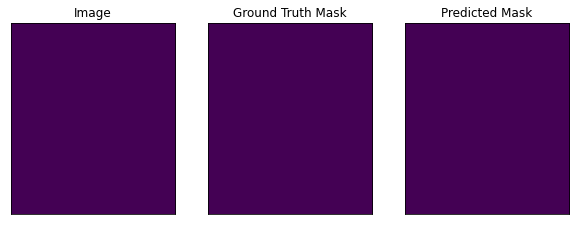

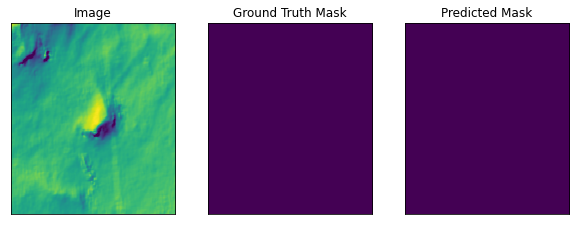

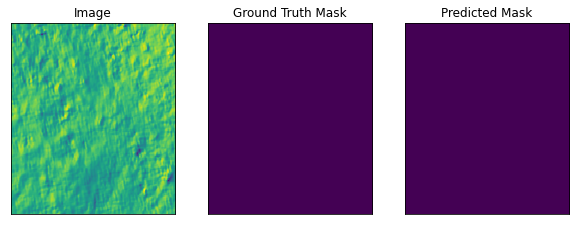

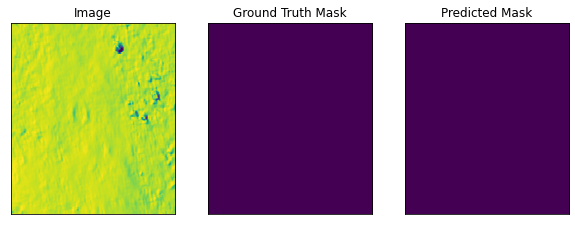

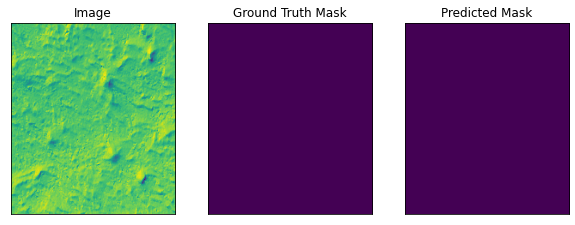

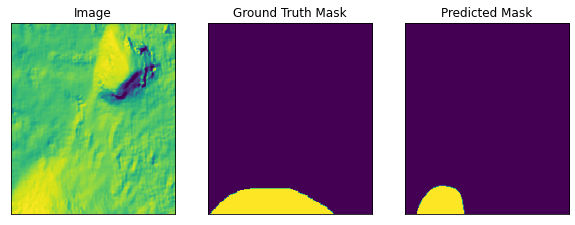

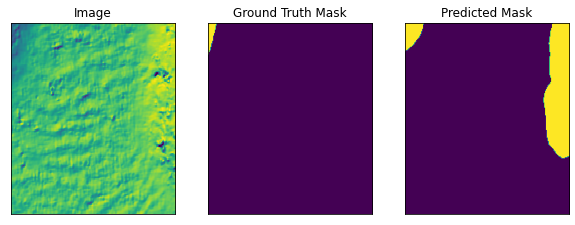

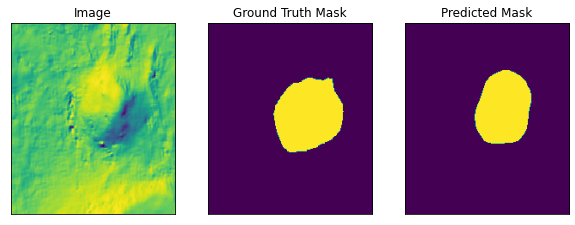

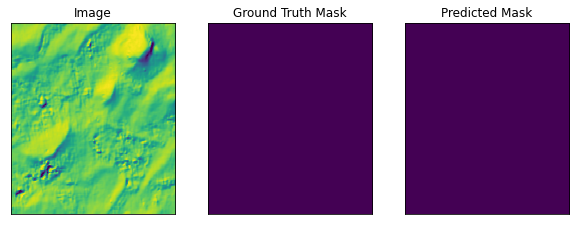

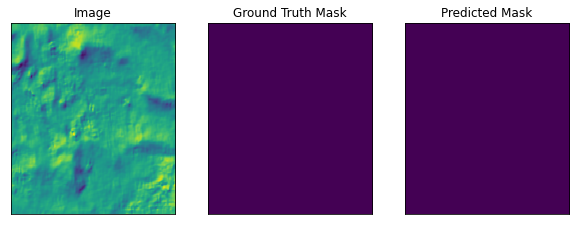

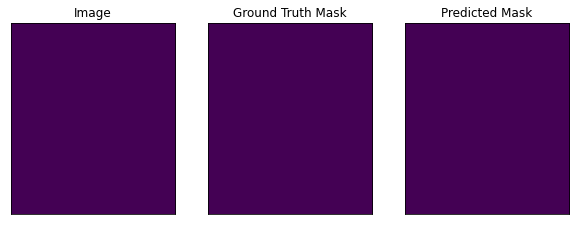

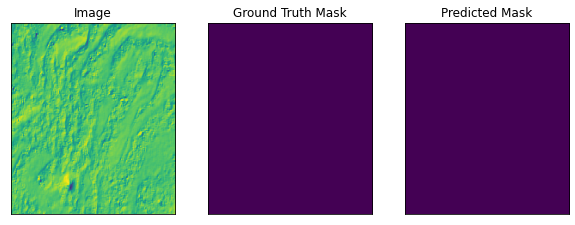

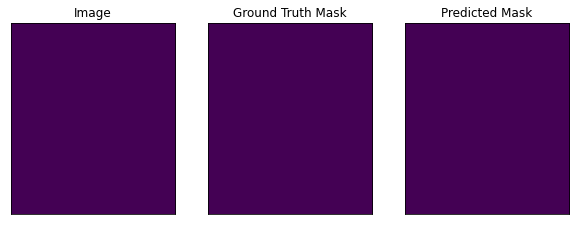

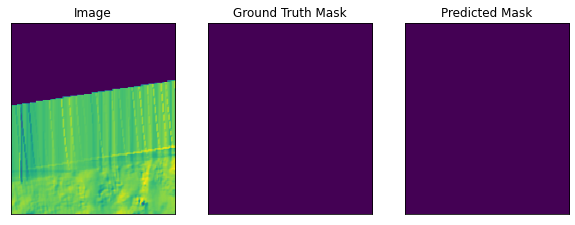

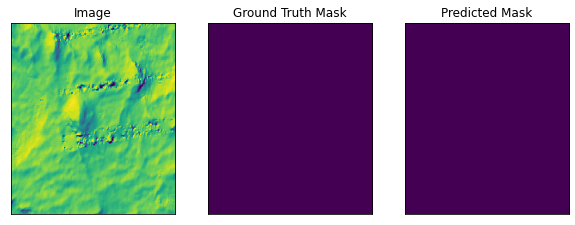

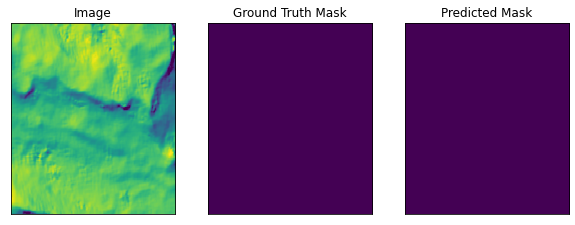

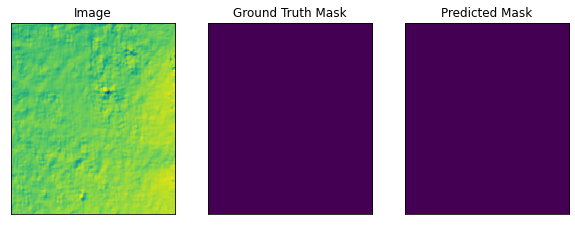

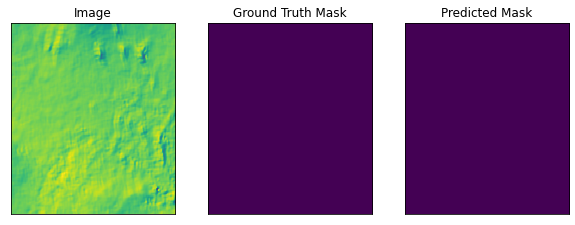

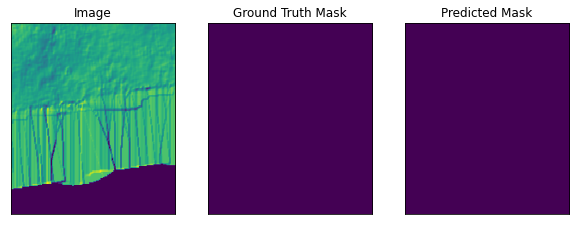

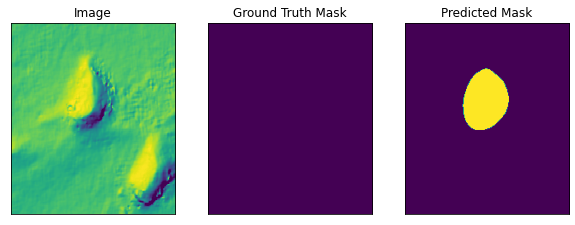

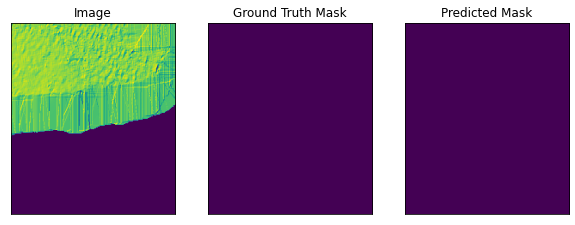

KeyboardInterrupt: 

In [30]:
# idx = [25, 30, 36, 38, 42, 53, 54]
for i in range(len(test_dataset)):
# for i in idx:
#     n = np.random.choice(len(test_dataset))
    n=i
    image_vis = test_dataset_vis[n][0]
    image, gt_mask = test_dataset[n]
    
    x_tensor = image.unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())

    visualize(
        image=image_vis[2], 
        ground_truth_mask=gt_mask[0], 
        predicted_mask=pr_mask
    )

In [31]:
from sklearn.metrics import confusion_matrix

In [32]:
def recall(tp, fn):
    if tp+fn == 0:
        return 'invalid'
    return float(tp)/float(tp+fn)

In [33]:
def precision(tp, fp):
    if tp+fp == 0:
        return 'invalid'
    return float(tp)/float(tp+fp)

In [34]:
def f1_score(tp, fp, fn):
    if tp+fp+fn == 0:
        return 'invalid'
    return float(tp)/(tp + (float(fp + fn)/2))

In [35]:
def for_metric(fn, tn):
    if fn+tn == 0:
        return 'invalid'
    return float(fn)/(fn+tn)

In [45]:
threshold = 0.5
results = pd.DataFrame(columns=['id', 'tp', 'fp', 'tn', 'fn', 'precision', 'recall'])
# for i, sample in enumerate(test_dataset):
# idx = [75, 256, 269, 321, 406, 415, 504]
for i in range(len(test_dataset)):
    correct = 0
    sample = test_dataset[i]
    im = sample[0].unsqueeze(0).float()#.to(device)
    mask = sample[1].float()#.to(device)
    out = best_model(im).detach()
    #compute output class
    pred = out
    pred[out >= threshold] = 1
    pred[out < threshold] = 0
    correct += (pred == mask).sum().item()
    total = len(mask.view(-1))
    accuracy = float(correct/total)
#     tp, fp, fn, tn = smp.metrics.get_stats(out, mask, mode='binary', threshold=0.5)
    # Sklearn doc
    tn, fp, fn, tp = confusion_matrix(mask.view(-1), pred.view(-1), labels=[0., 1.]).ravel()
    
    tmp = pd.DataFrame(columns=['id', 'tp', 'fp', 'tn', 'fn', 'precision', 'recall'])
    tmp['id'] = [i]
    tmp['tp'] = [tp]
    tmp['fp'] = [fp]
    tmp['tn'] = [tn]
    tmp['fn'] = [fn]
    tmp['recall'] = [recall(tp=tp, fn=fn)]
    tmp['precision'] = [precision(tp=tp, fp=fp)]
    results = results.append(tmp)

In [37]:
ttp = np.sum(results['tp'].values)
tfp = np.sum(results['fp'].values)
ttn = np.sum(results['tn'].values)
tfn = np.sum(results['fn'].values)

In [40]:
print(f'tp = {ttp}, fp = {tfp}, tn={ttn}, fn ={tfn}, precision = {precision(tp=ttp, fp=tfp)}, recall = {recall(tp=ttp, fn=tfn)} ')
print(f'F-Score = {f1_score(tp= ttp, fp= tfp, fn= tfn)}')

tp = 1691662, fp = 542787, tn=20880217, fn =367702, precision = 0.7570823948096377, recall = 0.8214487579660517 
F-Score = 0.7879532713697592


In [ ]:
idx = [75, 256, 269, 321, 406, 415, 504]
best_model = torch.load('./NEW_FPN_3c_With_Gan.pth')